# Section 4: Intro to Probability
Notes by Gloria Ha (2019),  Mary Richardson (2020), and Colin Hemez (2021)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Exercises

Now that we've gone over how to do this theoretically, let's try it on some data!  You can download the data at these links: [sleek_data.txt](sleek_data.txt) and [fluffy_data.txt](fluffy_data.txt).  Let's take a look at the *sleek* data file.

In [2]:
! head sleek_data.txt

rrsrrrrsrsrrsrr
srrrrsrsssrss
rsrsssrssrssrrrrs
srrrrrrrrsrssrs
rrsssrsssrssrs
srssrsssrsssr
srrsrrrsrsssrss
srrrrrsrssrssrss
srrssrssrssrs
ssrrrrsrrrsrrrssrssrsr


Looks like some sequences of 'r' and 's' of varying length!  The fluffy dataset is similar.  Note that each file has 1000 sequences.  We can now load in the data into lists (so we'll have lists of strings).

In [3]:
# Initialize sleek and fluffy data lists
sleek_data = []
fluffy_data = []

# Load data from files
with open('sleek_data.txt') as sleek_file:
    for line in sleek_file:
        sleek_data.append(line[:-1])
        
with open('fluffy_data.txt') as fluffy_file:
    for line in fluffy_file:
        fluffy_data.append(line[:-1])

### Exercise 1: See if you can use a simple zero order method to differentiate the birdsongs

See if you can use a simple scoring algorithm (+1 for 's' and -1 for 'r', for example) on the *sleek* and *fluffy* data to differentiate the sequences. 

I would recommend keeping two different arrays of length 1000: one for the scores you give to the sleek sequences, and one for the scores you gives to the fluffy sequences.

In [4]:
# Store length of data
num_seq = len(fluffy_data)

# Initialize score arrays
fluffy_scores = np.zeros(num_seq)
sleek_scores = np.zeros(num_seq)

# Write script to score sequences in both datasets
for i, seq in enumerate(sleek_data):
    score = 0
    for j in seq:
        if j=='s':
            score += 1
        if j=='r':
            score -=1
    sleek_scores[i] = score
    
fluffy_scores = np.zeros(len(fluffy_data))
for i, seq in enumerate(fluffy_data):
    score = 0
    for j in seq:
        if j=='s':
            score += 1
        if j=='r':
            score -=1
    fluffy_scores[i] = score    

Now that you have a score for every sequence in the dataset, try plotting a **histogram** of the distribution of scores for sleek and fluffy songs. Check out `plt.hist()`.

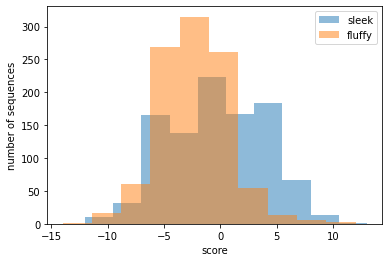

In [5]:
# Plot histogram of scores
plt.hist(sleek_scores, alpha=0.5, label='sleek');
plt.hist(fluffy_scores, alpha=0.5, label='fluffy');
plt.legend();
plt.xlabel('score');
plt.ylabel('number of sequences');

Try plotting a **ROC plot**. An easy way of going about this is to calculate the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) for each threshold score that you're considering. 

I would recommend first defining a range of threshold score values (for example, the minimum and the maximum of all of your scores), defining a linear space between those values (check out `np.linspace`), and then calculating the TP, TN, FP, FN for each threshold value. In this case, let's say that "positives" are scores above the threshold, and "negatives" are scores below the threshold (this is the typical definition). 

Remember that the ROC plot is true positive rate $\frac{TP}{TP+FN}$ vs. false positive rate $\frac{FP}{TN+FP}$.

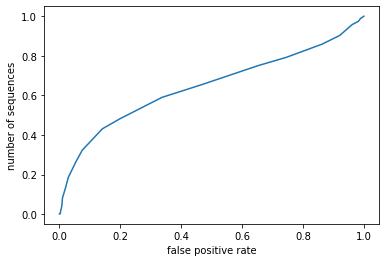

In [6]:
# Find minimum and maximum scores across both sleek and fluffy songs
min_score = np.min((fluffy_scores, sleek_scores))
max_score = np.max((fluffy_scores, sleek_scores))

# Define number and range of threshold scores
num_thresh = 1000
threshold_scores = np.linspace(min_score, max_score, 1000)

# Set up 
TP = np.zeros(num_thresh)
FP = np.zeros(num_thresh)
TN = np.zeros(num_thresh)
FN = np.zeros(num_thresh)

# Calculate TP/FN/TN/FP for each sequence in both datasets
for i, score in enumerate(threshold_scores):
    TP[i] = np.sum(sleek_scores>=score)
    FP[i] = np.sum(fluffy_scores>=score)
    TN[i] = np.sum(fluffy_scores<score)
    FN[i] = np.sum(sleek_scores<score)
    
# Plot it!
plt.plot(1-TN/(TN+FP), TP/(TP+FN));
plt.xlabel('false positive rate');
plt.ylabel('number of sequences');

How well does this method perform in distinguishing the songs?

### Exercise 2: Train a third order Markov model

#### Exercise 2.1: Split up your data into training and testing sets

Now for the fun part!

I would recommend first splitting up the data into **training and testing sets**. You can use half of the data for training and half for testing (like the homework), or choose some other fraction (as long as the training and testing sets don't overlap)!

In [7]:
# Split up training and testing sets
sleek_test = sleek_data[:num_seq//2]
sleek_train = sleek_data[num_seq//2:]
fluffy_test = fluffy_data[:num_seq//2]
fluffy_train = fluffy_data[num_seq//2:]

Now we want to use our training dataset to calculate the parameters of our Markov model. There are many ways you could go about this, so don't feel like you have to follow these steps!

As discussed in section, in order to calculate the **conditional probabilities** in the Markov model (ex: $P(s|srss)$), we can calculate the unconditional probabilities of the related 4-mers and 3-mers ($P(srss)$ and $P(srs)$ in this case).

How would we go about calculating these probabilities?  We want to see how many times each 4-mer appears in the data, and how many times each 3-mer appears in the data, for both *sleek* and *fluffy* songs.

#### Exercise 2.2: How many 4-mers and 3-mers are possible in this dataset?

One useful piece of information would be how many distinct 4-mers and 3-mers there are in the data.  We know that there are 2 states in this model: 's' and 'r'.  How many distinct 3-character and 4-character sequences are possible?  You could write them out by hand, or you could use probability (Hint: Does order matter? Are you sampling with replacement?)!

#### Exercise 2.3: Store distinct 4-mers and 3-mers in a list

Now we want to store the distinct 4-mers and 3-mers in a list. Something like `['ssss','sssr',...]` and `['sss','ssr',...]`.  Again, you could type out all possible combinations by hand, or you could harness the tools of Python to get all possible combinations (this will be even more useful with an alphabet of four letter like 'ACTG')! Check out `itertools`.  Again there are many ways to approach this, so feel free to diverge!

In [8]:
# Find all distinct 3-mer and 4-mer sequences and store them in lists
import itertools
from itertools import product

alph = ['s','r']
threemers = [''.join(i) for i in itertools.product(alph, repeat = 3)]
fourmers = [''.join(i) for i in itertools.product(alph, repeat = 4)]

Now we want to go through all of the training sequences and count how many times each 3-mer and 4-mer appears in the dataset.

#### Exercise 2.4: Find frequencies of distinct 3/4-mers in training data

Go through each sequence and identify each 3-mer and 4-mer, and update the counts of the corresponding 3-mers or 4-mers. Check out `list.index()`.

In [9]:
# Initialize counts array of 3-mers and 4-mers
threemer_counts_sleek = np.zeros(len(threemers))
threemer_counts_fluffy = np.zeros(len(threemers))
fourmer_counts_sleek = np.zeros(len(fourmers))
fourmer_counts_fluffy = np.zeros(len(fourmers))

# Go through each sequence and identify 3-mers and 4-mers and update counts
for seq in sleek_train:
    for i, note in enumerate(seq):
        if i<len(seq)-2:
            idx = threemers.index(seq[i:i+3])
            threemer_counts_sleek[idx]+=1
            if i<len(seq)-3:
                idx = fourmers.index(seq[i:i+4])
                fourmer_counts_sleek[idx]+=1
                
for seq in fluffy_train:
    for i, note in enumerate(seq):
        if i<len(seq)-2:
            idx = threemers.index(seq[i:i+3])
            threemer_counts_fluffy[idx]+=1
            if i<len(seq)-3:
                idx = fourmers.index(seq[i:i+4])
                fourmer_counts_fluffy[idx]+=1

Now you can normalize the counts to get frequencies, which we'll use as probabilities in our Markov models.

In [10]:
# Normalize counts to get frequencies/probabilities
fourmer_prob_fluffy = fourmer_counts_fluffy/np.sum(fourmer_counts_fluffy)
fourmer_prob_sleek = fourmer_counts_sleek/np.sum(fourmer_counts_sleek)
threemer_prob_fluffy = threemer_counts_fluffy/np.sum(threemer_counts_fluffy)
threemer_prob_sleek = threemer_counts_sleek/np.sum(threemer_counts_sleek)

Now we've trained our models! We can simply divide the relevant 3-mer and 4-mer probabilities when calculating the conditional probabilities. All that's left to do is to test the model on distinguishing the testing set sequences as *sleek* or *fluffy*.

### Exercise 3: Test the model

Use the equation for a third order Markov chain probability to calculate the probability of each sequence given the two Markov models (*sleek* and *fluffy*). Use these probabilities to calculate the log odds score, where in this case we are dividing the probability of being *sleek* by the probability of being *fluffy*. Remember that we want to use **logs of probabilities** whenever we are multiplying/dividing them together to avoid **underflow** errors.

In [11]:
# Initialize score array
fluffy_scores = np.zeros(len(fluffy_test))
sleek_scores = np.zeros(len(sleek_test))

# Iterate through each sequence
sleek_scores = np.zeros(len(sleek_test))
fluffy_scores = np.zeros(len(fluffy_test))

for j, seq in enumerate(sleek_test):
    # For each sequence, calculate the initial probability 
    # of the first three notes under both models
    idx = threemers.index(seq[:3])
    sleek_prob = np.log(fourmer_prob_sleek[idx])
    fluffy_prob = np.log(fourmer_prob_fluffy[idx])
    
    # For each sequence, calculate the probabilities of each note given
    # the previous three notes (starting with the fourth note) under both models
    for i, note in enumerate(seq[3:]):
        fourmer_idx = fourmers.index(seq[i:i+4])
        threemer_idx = threemers.index(seq[i:i+3])
        sleek_prob+= np.log(fourmer_prob_sleek[fourmer_idx])-np.log(fourmer_prob_sleek[threemer_idx])
        fluffy_prob+=np.log(fourmer_prob_fluffy[fourmer_idx])-np.log(fourmer_prob_fluffy[threemer_idx])
        
    # For each sequence, calculate a log-odds score and store it
    sleek_scores[j] = sleek_prob-fluffy_prob
    
for j, seq in enumerate(fluffy_test):
    # For each sequence, calculate the initial probability 
    # of the first three notes under both models
    idx = threemers.index(seq[:3])
    sleek_prob = np.log(fourmer_prob_sleek[idx])
    fluffy_prob = np.log(fourmer_prob_fluffy[idx])
    
    # For each sequence, calculate the probabilities of each note given
    # the previous three notes (starting with the fourth note) under both models
    for i, note in enumerate(seq[3:]):
        fourmer_idx = fourmers.index(seq[i:i+4])
        threemer_idx = threemers.index(seq[i:i+3])
        sleek_prob+= np.log(fourmer_prob_sleek[fourmer_idx])-np.log(fourmer_prob_sleek[threemer_idx])
        fluffy_prob+=np.log(fourmer_prob_fluffy[fourmer_idx])-np.log(fourmer_prob_fluffy[threemer_idx])
        
    # For each sequence, calculate a log-odds score and store it
    fluffy_scores[j] = sleek_prob-fluffy_prob

Now you should have two arrays of scores, one for the *sleek* test dataset, and one for the *fluffy* test dataset. You can now repeat the histogram and ROC plot part of exercise 1 on these new scores. Did the model do any better? What's the **specificity** if you set a **sensitivity** threshold of 0.9 or higher? What if the *sleek* songs only made up 1% of the total songs? What would the **false discovery rate** be?

### Notes

For the purposes of this exercise, I split everything up and wrote a lot of repetitive code. In your actual homework, you can consider putting scripts into functions. If you're interested in doing more with this dataset, you could see if generating random note sequences would be distinguishable from *sleek* sequences under a zero order model. You could also see if these sequences could be better distinguished with any other order of Markov model (though, they were generated under a third order model...).

Text(0, 0.5, 'number of sequences')

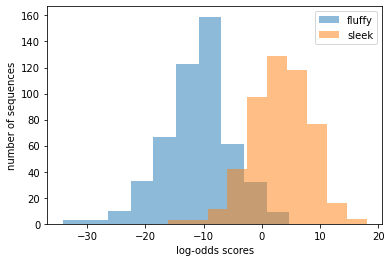

In [12]:
# Plot a histogram
plt.hist(fluffy_scores, alpha=0.5);
plt.hist(sleek_scores, alpha=0.5);
plt.legend(['fluffy', 'sleek']);
plt.xlabel('log-odds scores');
plt.ylabel('number of sequences')

In [13]:
# Calculate TP, FP, TN, FN at each threshold score
min_score = np.min((fluffy_scores, sleek_scores))
max_score = np.max((fluffy_scores, sleek_scores))
score_range = np.linspace(min_score, max_score, 1000)

TP = np.zeros(len(score_range))
FP = np.zeros(len(score_range))
TN = np.zeros(len(score_range))
FN = np.zeros(len(score_range))

for i, score in enumerate(score_range):
    TP[i] = np.sum(sleek_scores>=score)
    FP[i] = np.sum(fluffy_scores>=score)
    TN[i] = np.sum(fluffy_scores<score)
    FN[i] = np.sum(sleek_scores<score)

Text(0, 0.5, 'sensitivity')

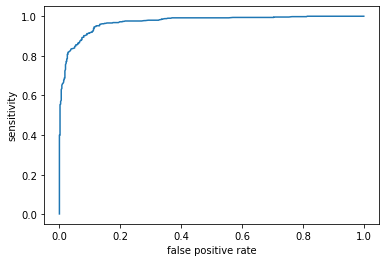

In [14]:
# Plot a ROC plot
plt.plot(1-TN/(TN+FP), TP/(TP+FN))
plt.xlabel('false positive rate')
plt.ylabel('sensitivity')

In [15]:
# Find index where false positive rate is <5%
thresh_idx = np.where(1-TN/(TN+FP)<0.05)[0][0]

# Find corresponding score
thresh = threshold_scores[thresh_idx]

# Find corresponding sensitivity
sensitivity = TP/(TP+FN)
thresh_sensitivity = sensitivity[thresh_idx]

print('For FPR<5%, need threshold greater than', str(thresh), ' with resulting sensitivity ', str(thresh_sensitivity))

For FPR<5%, need threshold greater than 2.9729729729729755  with resulting sensitivity  0.836


In [16]:
# Find FDR for false positive rate <5% if 1% of population is special
FDR = (FP*0.99)/(TP*0.01+FP*0.99)

print('For FPR<5%, if 1 percent of population is special, FDR is ', str(FDR[thresh_idx]))

For FPR<5%, if 1 percent of population is special, FDR is  0.8325991189427313
